In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from collections import Counter
from scipy.stats import linregress
from math import e
from scipy import odr

In [51]:
def redistribute_force(F, L, alpha, F_thr, neighborhood='moore'):
    # Create a copy of the forces to store the new values
    F_new = np.copy(F)
    # List of active sites
    active_sites_1 = []

    # Find active sites
    # for i in range(L):
    #     for j in range(L):
    #         if F[i, j] >= F_thr:
    #             active_sites_1.append((i, j))


    active_mask = F >= F_thr

    # Use np.argwhere to find the indices where the condition is True
    active_sites = np.argwhere(active_mask)

    # Convert the indices to a list of tuples
    active_sites = list(map(tuple, active_sites))


    # Redistribute forces from active sites
    for site in active_sites:
        i, j = site
        force_to_redistribute = F[i, j]

        # Define the neighborhood for force redistribution
        if neighborhood == 'moore':
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1),
                         (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        else:  # von Neumann neighborhood
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

        # count no of neighbors 
        neighbors_count = 0    
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                neighbors_count += 1
        
        # Redistribute the force to the neighbors
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                F_new[ni, nj] += (alpha * force_to_redistribute)/neighbors_count

        # Set the force of the active site to zero
        F_new[i, j] = 0

    return F_new, active_sites

def simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore'):
    # Initialize the grid with random forces
    F = np.random.rand(L, L) * F_thr
    initial_state = np.copy(F)

    active = True
    active_sites_count = 0
    active_sites_array = []
    while active:
        # Redistribute forces and get list of active sites
        F, active_sites = redistribute_force(F, L, alpha, F_thr, neighborhood)
        # If there are no active sites, break the loop
        active = len(active_sites) > 0
        active_sites_count += len(active_sites)

        if not active and n_additions > 0:
            # Locate site with the block closest to slip
            i, j = np.unravel_index(np.argmin(F_thr - F), F.shape)
            # Add the difference to all sites
            F += (F_thr - F[i, j])
            n_additions -= 1
            active_sites_array.append(active_sites_count)
            active_sites_count = 0
            active = True

    return initial_state, F, active_sites_array

def visualize_states(initial_state, final_state, title='Cellular Automata States'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Initial state visualization
    ax1 = axes[0]
    im1 = ax1.imshow(initial_state, cmap='viridis', interpolation='nearest')
    ax1.set_title('Initial State')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    # Final state visualization
    ax2 = axes[1]
    im2 = ax2.imshow(final_state, cmap='viridis', interpolation='nearest')
    ax2.set_title('Final State')
    fig.colorbar(im2, ax=ax2, orientation='vertical')

    # Overall title and show
    plt.suptitle(title)
    plt.show()

In [53]:
# Parameters
L = 50  # Size of the lattice
alpha = 0.5  # Coupling constant
F_thr = 4.0  # Threshold force
n_additions = 50000 # Number of additions of force to the system

# Run a simulation for Moore neighborhood
initial_state_moore, final_state_moore, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')

# Visualize the initial and final states for Moore neighborhood simulation
#visualize_states(initial_state_moore, final_state_moore, title='Cellular Automata States (Moore Neighborhood)')

# Run a simulation for Von Neumann neighborhood
initial_state_von, final_state_von, active_sites_von = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='von_neumann')

# Visualize the initial and final states for Von Neumann neighborhood simulation
#visualize_states(initial_state_von, final_state_von, title='Cellular Automata States (Von Neumann Neighborhood)')

In [4]:
def multiple_runs(n_simulations, nbh):
    """This function runs the simulation multiple times to reduce the noise in the results.
    The input parameters are the number of simulations and the neighborhood type.
    The output is a list of the active sites for each simulation.
    """
    active_sites_array = []
    for i in range(n_simulations):
        _, _, active_sites = simulate_ca(L, alpha, F_thr, n_additions, neighborhood=nbh)
        active_sites_array.append(active_sites)
        
    return active_sites_array

def clean_data(active_sites_arrray):
    """This function flattens the input array and, sorts it by the number of occurences
    and returns a dictionary with the number of occurences of each magnitude.
    """
    # Flatten the array
    flat_list = [item for sublist in active_sites_arrray for item in sublist]

    # Create a dict to store the number of occurences of each magnitude
    occurrences_counter = Counter(flat_list)
    occurences_dict = dict(sorted(occurrences_counter.items()))

    # Remove the magnitude 0
    del occurences_dict[0]
    
    return occurences_dict

In [5]:
# Orthogonal Distance Regression（ODR）
def linear_func(p, x):
    """This function is designed to do the linear regression. 
    It returns the slope and the intercept
    """
    a, b = p
    return a * x + b

Moore runs

In [6]:
# run multiple simulations for Moore neighborhood
active_sites_moore_array = multiple_runs(25, 'moore')

# clean the Moore data
occurences_moore_dict = clean_data(active_sites_moore_array)

# Isolate the values and frequencies
values_moore = np.array(list(occurences_moore_dict.keys()))
frequencies_moore = np.array(list(occurences_moore_dict.values()))

slope_m, intercept_m, r_value_m, p_value_m, std_err_m = linregress(np.log(values_moore), np.log(frequencies_moore))

In [7]:
print("Slope:", slope_m)
print("Intercept:", intercept_m)
print("R-squared:", r_value_m**2)
print("P-value:", p_value_m)

Slope: -3.1915267676313976
Intercept: 12.986251949242728
R-squared: 0.978095061910355
P-value: 2.50801181311652e-47


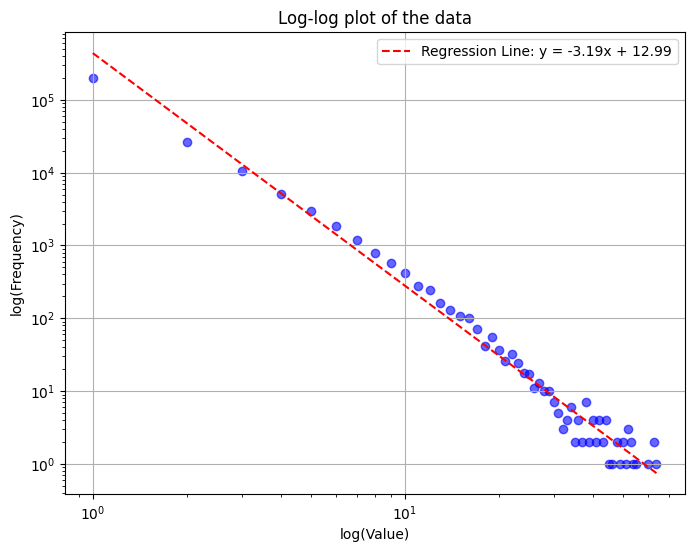

In [8]:
# Plot the Moore data in a log-log plot
plt.figure(figsize=(8, 6))
plt.scatter(values_moore, frequencies_moore, color='blue', alpha=0.6)
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-log plot of the data')

x = np.linspace(min(np.log(values_moore)), max(np.log(values_moore)), 100)
y = slope_m * x + intercept_m
plt.plot(e ** x,e ** y, color='red', linestyle='--', label=f'Regression Line: y = {slope_m:.2f}x + {intercept_m:.2f}')
plt.legend()

plt.grid(True)
plt.show()

Do linear regression with ODR

In [9]:
# Use ODR to do Linear Regression
linear_model = odr.Model(linear_func)
data = odr.Data(np.log(values_moore), np.log(frequencies_moore))
odr_obj = odr.ODR(data, linear_model, beta0=[0., 1.])
output = odr_obj.run()

slope, intercept = output.beta
r_squared = output.res_var
p_value = output.cov_beta[0, 0]
std_err = output.sd_beta

In [10]:
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_squared)
print("P-value:", p_value)

Slope: -3.256729331967386
Intercept: 13.188578562640396
R-squared: 0.01674940299932437
P-value: 0.25694179353106


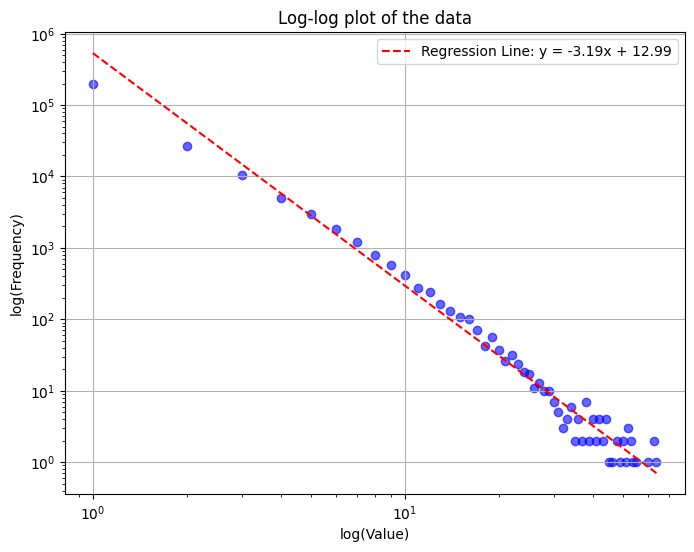

In [11]:
# Plot the Moore data in a log-log plot
plt.figure(figsize=(8, 6))
plt.scatter(values_moore, frequencies_moore, color='blue', alpha=0.6)
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-log plot of the data')

x = np.linspace(min(np.log(values_moore)), max(np.log(values_moore)), 100)
y = slope * x + intercept
plt.plot(e ** x,e ** y, color='red', linestyle='--', label=f'Regression Line: y = {slope_m:.2f}x + {intercept_m:.2f}')
plt.legend()

plt.grid(True)
plt.show()

Von Neumann runs

In [12]:
# run multiple simulations for Von Neumann neighborhood
active_sites_vn_array = multiple_runs(25, 'von_neumann')

# clean the Von Neumann data
occurences_vn_dict = clean_data(active_sites_vn_array)

# Isolate the values and frequencies
values_vn = np.array(list(occurences_vn_dict.keys()))
frequencies_vn = np.array(list(occurences_vn_dict.values()))

slope_vn, intercept_vn, r_value_vn, p_value_vn, std_err_vn = linregress(np.log(values_vn), np.log(frequencies_vn))

In [13]:
print("Slope:", slope_vn)
print("Intercept:", intercept_vn)
print("R-squared:", r_value_vn**2)
print("P-value:", p_value_vn)

Slope: -2.298224280894217
Intercept: 13.183332319272711
R-squared: 0.8429735464530419
P-value: 6.214962659560045e-57


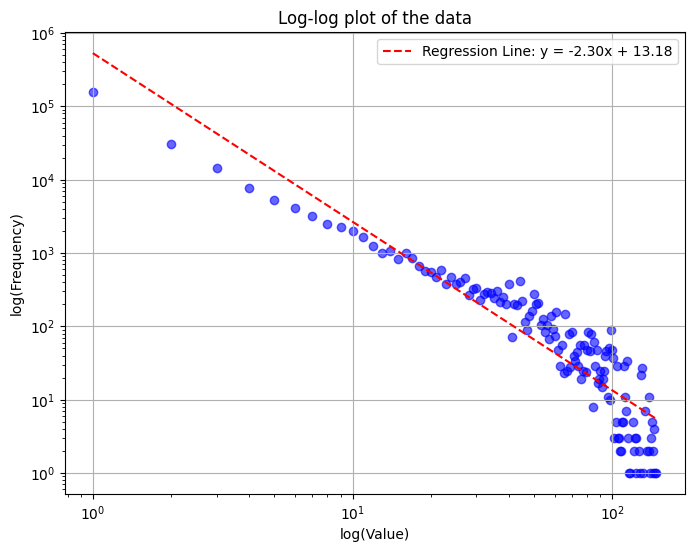

In [14]:
# Plot the Von Neumann data in a log-log plot
plt.figure(figsize=(8, 6))
plt.scatter(values_vn, frequencies_vn, color='blue', alpha=0.6)
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-log plot of the data')

x = np.linspace(min(np.log(values_vn)), max(np.log(values_vn)), 100)
y = slope_vn * x + intercept_vn
plt.plot(e ** x,e ** y, color='red', linestyle='--', label=f'Regression Line: y = {slope_vn:.2f}x + {intercept_vn:.2f}')
plt.legend()

plt.grid(True)
plt.show()

Running simulation for alpha=0.1, L=15, Threshold=2.0...
50% 

100% Running simulation for alpha=0.1, L=25, Threshold=2.0...
50% 100% Running simulation for alpha=0.1, L=50, Threshold=2.0...
50% 100% Running simulation for alpha=0.1, L=15, Threshold=4.0...
50% 100% Running simulation for alpha=0.1, L=25, Threshold=4.0...
50% 100% Running simulation for alpha=0.1, L=50, Threshold=4.0...
50% 100% Running simulation for alpha=0.1, L=15, Threshold=6.0...
50% 100% Running simulation for alpha=0.1, L=25, Threshold=6.0...
50% 100% Running simulation for alpha=0.1, L=50, Threshold=6.0...
50% 100% Running simulation for alpha=0.2, L=15, Threshold=2.0...
50% 100% Running simulation for alpha=0.2, L=25, Threshold=2.0...
50% 100% Running simulation for alpha=0.2, L=50, Threshold=2.0...
50% 100% Running simulation for alpha=0.2, L=15, Threshold=4.0...
50% 100% Running simulation for alpha=0.2, L=25, Threshold=4.0...
50% 100% Running simulation for alpha=0.2, L=50, Threshold=4.0...
50% 100% Running simulation for alpha=0.2, L=15, Threshold=6.0...
50% 100% Runni

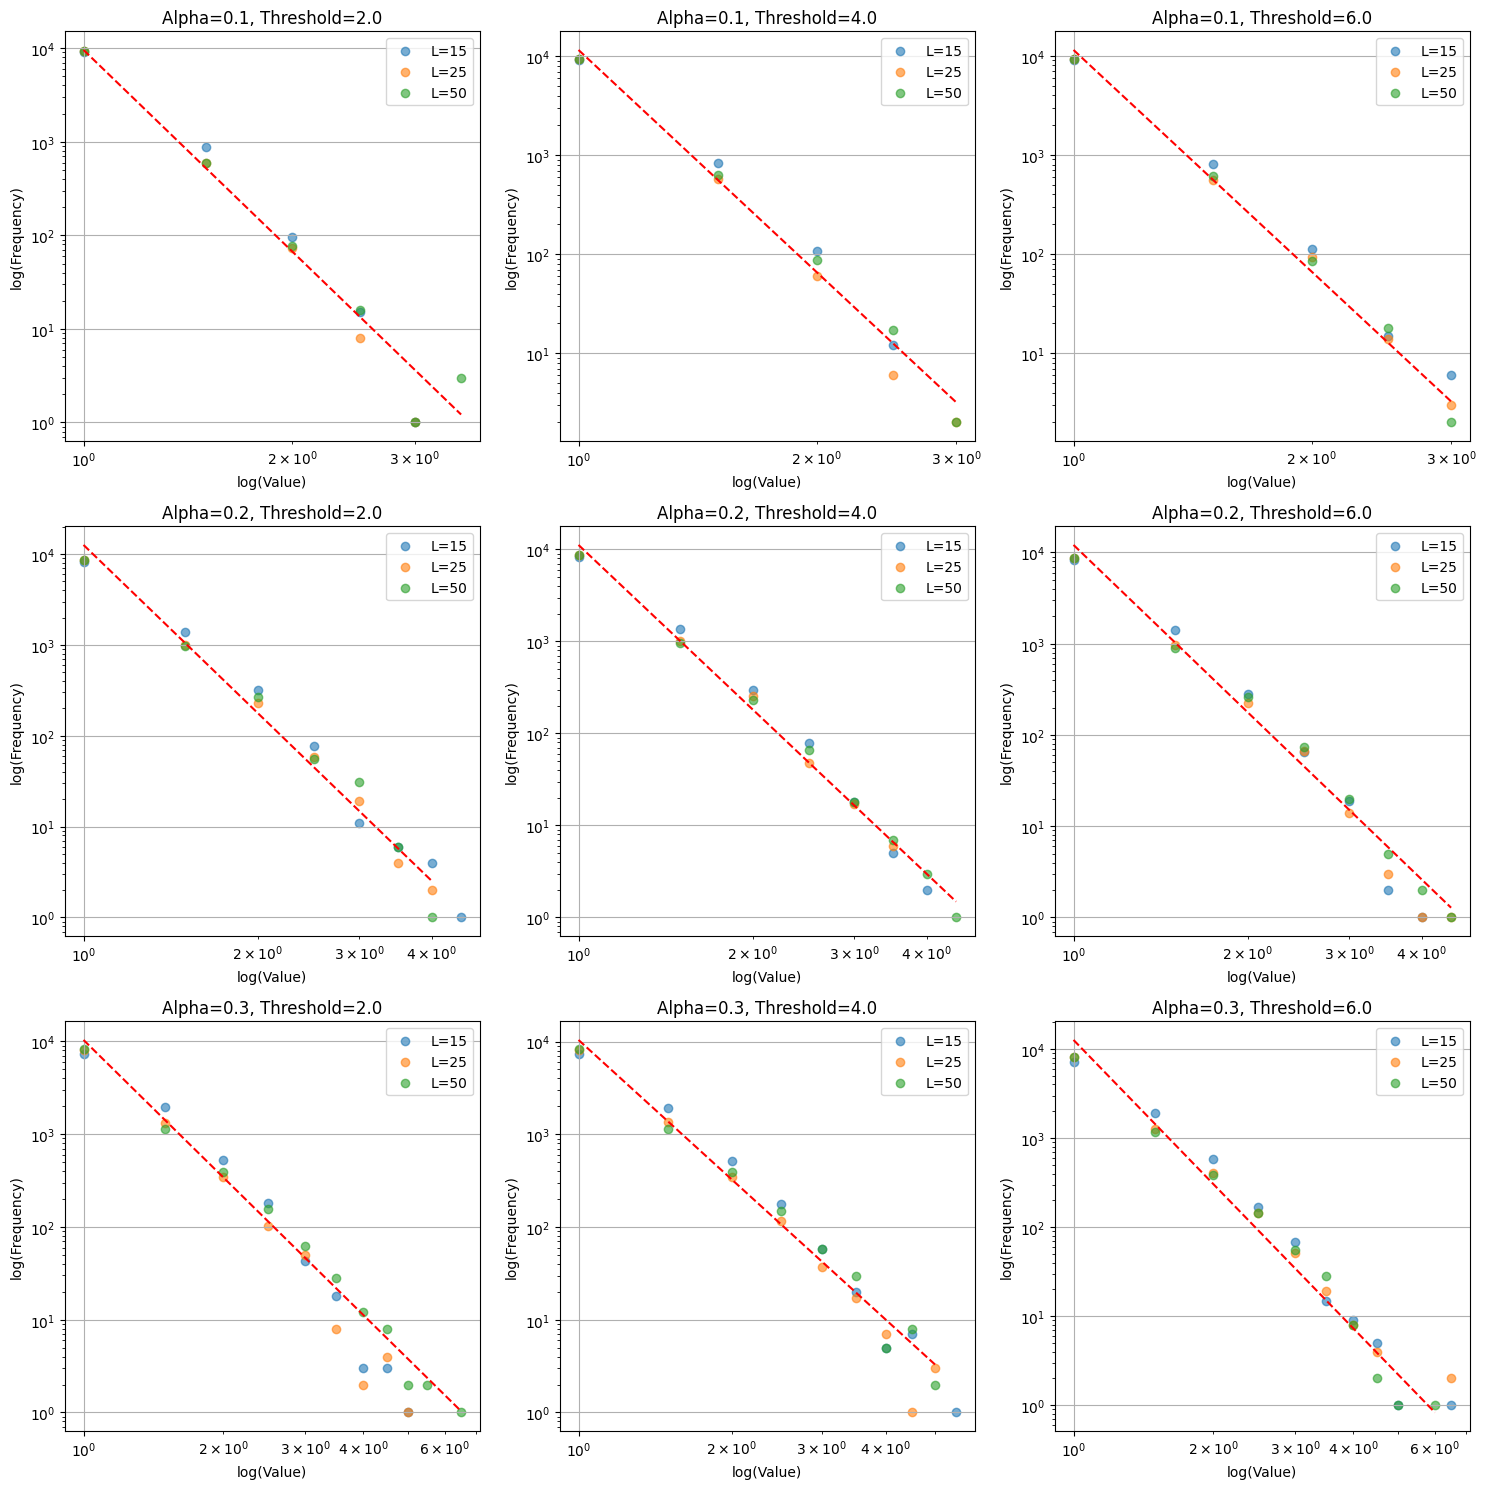

In [58]:
# Define parameters to vary
alphas = [0.1, 0.2, 0.3]  # Varying values for alpha
L_values = [15, 25, 50]     # Varying values for L
thresholds = [2.0, 4.0, 6.0] # Varying values for threshold

# Number of additions of force to the system
n_additions = 10000

# Number of simulations
n_simulations = 2

# Create a 3x3 plot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over different values of alpha, L, and threshold
for i, alpha in enumerate(alphas):
    for j, F_thr in enumerate(thresholds):
        for k, L in enumerate(L_values):
            print(f"Running simulation for alpha={alpha}, L={L}, Threshold={F_thr}...")
            
            # Arrays to store results of each simulation
            active_sites_moore_array = []
            
            # Perform simulations
            for z in range(n_simulations):
                print(round((z+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
                _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')
                active_sites_moore_array.append(active_sites_moore)
            
            # Compute the average of the results
            average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
            
            # Process data
            occurrences_counter = Counter(average_active_sites_moore)
            magnitudes = list(occurrences_counter.keys())
            frequencies = list(occurrences_counter.values())
            values = np.array(list(occurrences_counter.keys()))
            frequencies = np.array(list(occurrences_counter.values()))
            
            

            # Filter
            non_zero_indices = values > 0
            values = values[non_zero_indices]
            frequencies = frequencies[non_zero_indices]

            # Plot on the corresponding subplot
            ax = axes[i, j]
            ax.scatter(values, frequencies, label=f'L={L}', alpha=0.6)
            ax.set_xlabel('log(Value)')
            ax.set_ylabel('log(Frequency)')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_title(f'Alpha={alpha}, Threshold={F_thr}')
            ax.legend()
            ax.grid(True)

        # Perform linear regression
        slope, intercept, _, _, _ = linregress(np.log(values), np.log(frequencies))
        x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
        y = slope * x + intercept
        ax.plot(np.exp(x), np.exp(y), color = 'red', linestyle = '--', label = f'Regression line: y = {slope:.2f}x + {intercept:.2f}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

ODR

Running simulation for alpha=0.7, L=50, Threshold=2.0...
50% 100% Running simulation for alpha=0.7, L=100, Threshold=2.0...
50% 100% Running simulation for alpha=0.7, L=200, Threshold=2.0...
50% 100% Running simulation for alpha=0.7, L=50, Threshold=4.0...
50% 100% Running simulation for alpha=0.7, L=100, Threshold=4.0...
50% 100% Running simulation for alpha=0.7, L=200, Threshold=4.0...
50% 100% Running simulation for alpha=0.7, L=50, Threshold=6.0...
50% 100% Running simulation for alpha=0.7, L=100, Threshold=6.0...
50% 100% Running simulation for alpha=0.7, L=200, Threshold=6.0...
50% 100% Running simulation for alpha=0.8, L=50, Threshold=2.0...
50% 100% Running simulation for alpha=0.8, L=100, Threshold=2.0...
50% 100% Running simulation for alpha=0.8, L=200, Threshold=2.0...
50% 100% Running simulation for alpha=0.8, L=50, Threshold=4.0...
50% 100% Running simulation for alpha=0.8, L=100, Threshold=4.0...
50% 100% Running simulation for alpha=0.8, L=200, Threshold=4.0...
50% 100% 

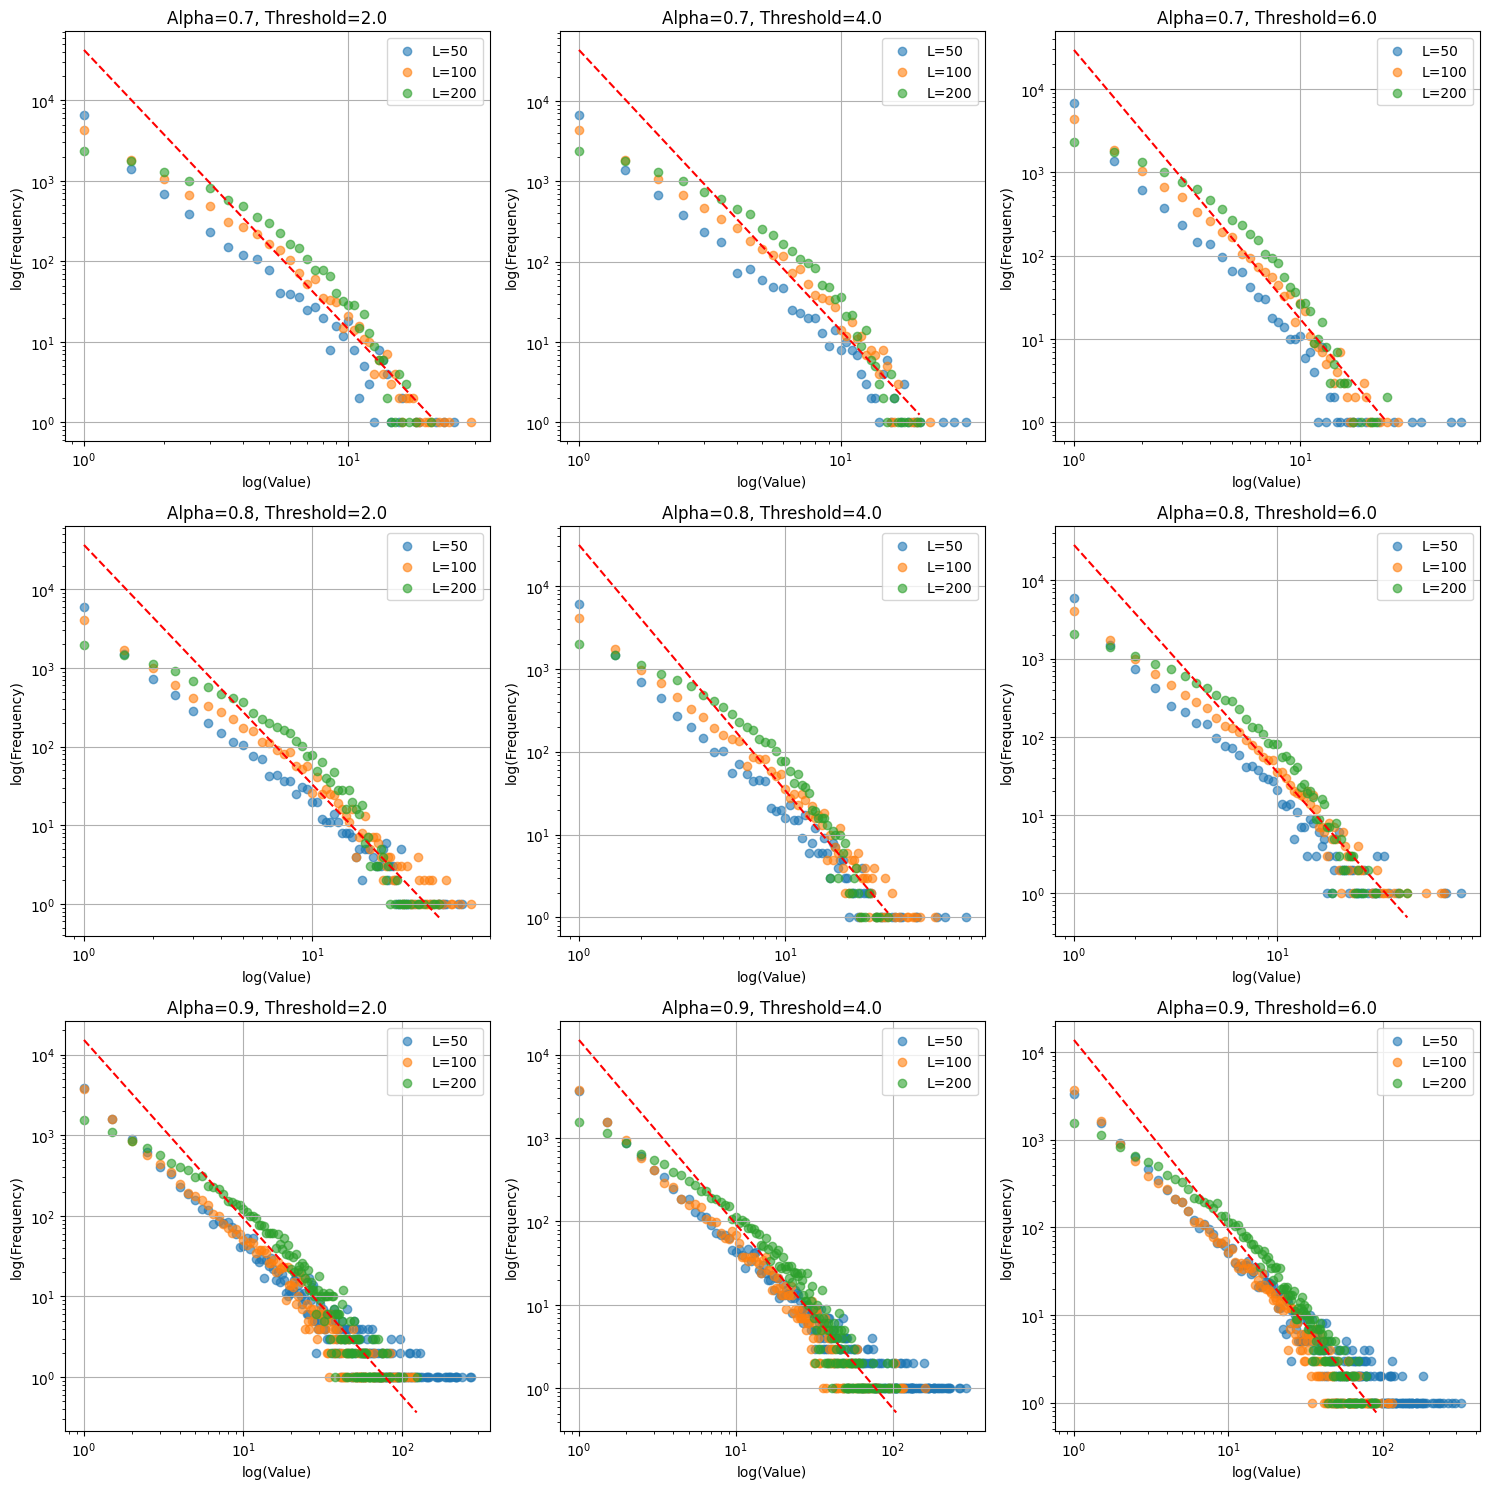

In [57]:
# Parameters
alphas = [0.7, 0.8, 0.9]  # Varying values for alpha
L_values = [50, 100, 200]     # Varying values for L
thresholds = [2.0, 4.0, 6.0] # Varying values for threshold

n_additions = 10000  # Number of additions of force to the system

# Number of simulations
n_simulations = 2

# Create a 3x3 plot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, alpha in enumerate(alphas):
    for j, F_thr in enumerate(thresholds):
        for k, L in enumerate(L_values):
            print(f"Running simulation for alpha={alpha}, L={L}, Threshold={F_thr}...")
            
            # Arrays to store results of each simulation
            active_sites_moore_array = []

            for z in range(n_simulations):
                print(round((z+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
                _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, 'moore')
                active_sites_moore_array.append(active_sites_moore)

            # Compute the average of the results
            average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
            
            # Process data
            occurrences_counter = Counter(average_active_sites_moore)
            magnitudes = list(occurrences_counter.keys())
            frequencies = list(occurrences_counter.values())
            values = np.array(list(occurrences_counter.keys()))
            frequencies = np.array(list(occurrences_counter.values()))

            non_zero_indices = values > 0
            values = values[non_zero_indices]
            frequencies = frequencies[non_zero_indices]


            # Use ODR to do Linear Regression
            linear_model = odr.Model(linear_func)
            data = odr.Data(np.log(values), np.log(frequencies))
            odr_obj = odr.ODR(data, linear_model, beta0=[0., 1.])
            output = odr_obj.run()

            slope, intercept = output.beta
            r_squared = output.res_var
            p_value = output.cov_beta[0, 0]
            std_err = output.sd_beta

            # Plot on the corresponding subplot
            ax = axes[i, j]
            ax.scatter(values, frequencies, label=f'L={L}', alpha=0.6)
            ax.set_xlabel('log(Value)')
            ax.set_ylabel('log(Frequency)')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_title(f'Alpha={alpha}, Threshold={F_thr}')
            ax.legend()
            ax.grid(True)

        x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
        y = slope * x + intercept
        ax.plot(e ** x, e ** y, color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

plt.tight_layout()              
plt.show()


Lattice and threshold fixed, change alpha

Running simulation for alpha=0.1, L=25, Threshold=4.0...
33% 

67% 100% 

Running simulation for alpha=0.15, L=25, Threshold=4.0...
33% 67% 100% 

Running simulation for alpha=0.2, L=25, Threshold=4.0...
33% 67% 100% 

Running simulation for alpha=0.25, L=25, Threshold=4.0...
33% 67% 100% 



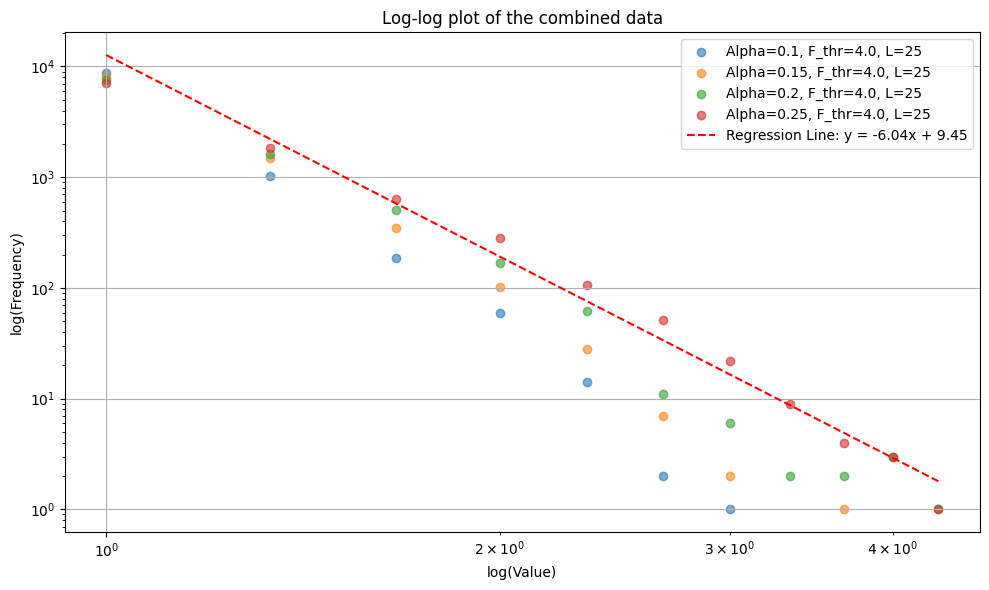

In [17]:
# Define parameters to vary
alphas = [0.1, 0.15, 0.2, 0.25]  # Varying values for alpha
L_values = [25]     # Varying values for L
thresholds = [4.0] # Varying values for threshold

# Number of additions of force to the system
n_additions = 10000

# Number of simulations
n_simulations = 3

# Create a single plot
plt.figure(figsize=(10, 6))

# Iterate over different values of alpha and L
for i, alpha in enumerate(alphas):
    for j, F_thr in enumerate(thresholds):
        for k, L in enumerate(L_values):
            print(f"Running simulation for alpha={alpha}, L={L}, Threshold={F_thr}...")
            
            # Arrays to store results of each simulation
            active_sites_moore_array = []
        
            for z in range(n_simulations):
                print(round((z+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
                _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, 'moore')
                active_sites_moore_array.append(active_sites_moore)

        
            # Compute the average of the results
            average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
            
            # Process data
            occurrences_counter = Counter(average_active_sites_moore)
            magnitudes = list(occurrences_counter.keys())
            frequencies = list(occurrences_counter.values())
            values = np.array(list(occurrences_counter.keys()))
            frequencies = np.array(list(occurrences_counter.values()))

            # Filter
            non_zero_indices = values > 0
            values = values[non_zero_indices]
            frequencies = frequencies[non_zero_indices]
            
            # Use ODR to do Linear Regression
            linear_model = odr.Model(linear_func)
            data = odr.Data(np.log(values), np.log(frequencies))
            odr_obj = odr.ODR(data, linear_model, beta0=[0., 1.])
            output = odr_obj.run()

            slope, intercept = output.beta
            r_squared = output.res_var
            p_value = output.cov_beta[0, 0]
            std_err = output.sd_beta
            
            # Plot the data points with a unique color for each combination
            plt.scatter(values, frequencies, label=f'Alpha={alpha}, F_thr={F_thr}, L={L}', alpha=0.6)
            print("\n")

# Add linear regression line
x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept
plt.plot(np.exp(x), np.exp(y), color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

# Set plot labels and title
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-log plot of the combined data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

alpha and thresholds fixed, change Lattice

Running simulation for alpha=0.5, L=15, Threshold=4.0...
20% 40% 60% 80% 100% 

Running simulation for alpha=0.5, L=25, Threshold=4.0...
20% 40% 60% 80% 100% 

Running simulation for alpha=0.5, L=50, Threshold=4.0...
20% 40% 60% 80% 100% 

Running simulation for alpha=0.5, L=100, Threshold=4.0...
20% 40% 60% 80% 100% 



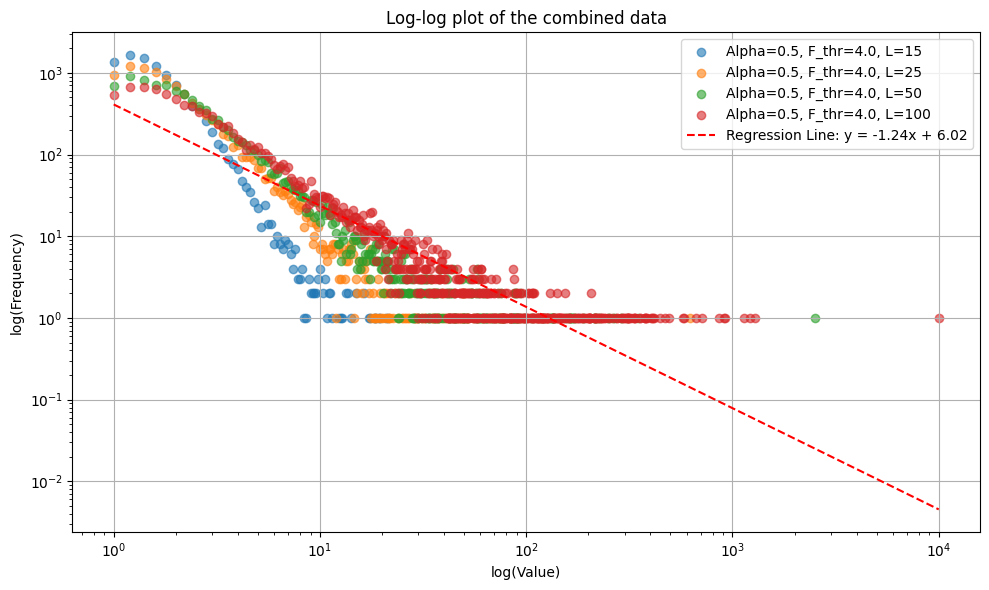

In [ ]:
# Define parameters to vary
alphas = [0.5]  # Varying values for alpha
L_values = [15, 25, 50, 100]     # Varying values for L
thresholds = [4.0] # Varying values for threshold

# Number of additions of force to the system
n_additions = 10000

# Number of simulations
n_simulations = 5

# Create a single plot
plt.figure(figsize=(10, 6))

# Iterate over different values of alpha and L
for i, alpha in enumerate(alphas):
    for j, F_thr in enumerate(thresholds):
        for k, L in enumerate(L_values):
            print(f"Running simulation for alpha={alpha}, L={L}, Threshold={F_thr}...")
            
            # Arrays to store results of each simulation
            active_sites_moore_array = []
        
            for z in range(n_simulations):
                print(round((z+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
                _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, 'moore')
                active_sites_moore_array.append(active_sites_moore)

        
            # Compute the average of the results
            average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
            
            # Process data
            occurrences_counter = Counter(average_active_sites_moore)
            magnitudes = list(occurrences_counter.keys())
            frequencies = list(occurrences_counter.values())
            values = np.array(list(occurrences_counter.keys()))
            frequencies = np.array(list(occurrences_counter.values()))

            # Filter
            non_zero_indices = values > 0
            values = values[non_zero_indices]
            frequencies = frequencies[non_zero_indices]
            
            # Use ODR to do Linear Regression
            linear_model = odr.Model(linear_func)
            data = odr.Data(np.log(values), np.log(frequencies))
            odr_obj = odr.ODR(data, linear_model, beta0=[0., 1.])
            output = odr_obj.run()

            slope, intercept = output.beta
            r_squared = output.res_var
            p_value = output.cov_beta[0, 0]
            std_err = output.sd_beta
            
            # Plot the data points with a unique color for each combination
            plt.scatter(values, frequencies, label=f'Alpha={alpha}, F_thr={F_thr}, L={L}', alpha=0.6)
            print("\n")

# Add linear regression line
x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept
plt.plot(np.exp(x), np.exp(y), color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

# Set plot labels and title
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-log plot of the combined data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Running simulation for alpha=0.1, L=50, Threshold=3.0...
20% 40% 60% 80% 100% 

Running simulation for alpha=0.1, L=50, Threshold=8.0...
20% 40% 60% 80% 100% 



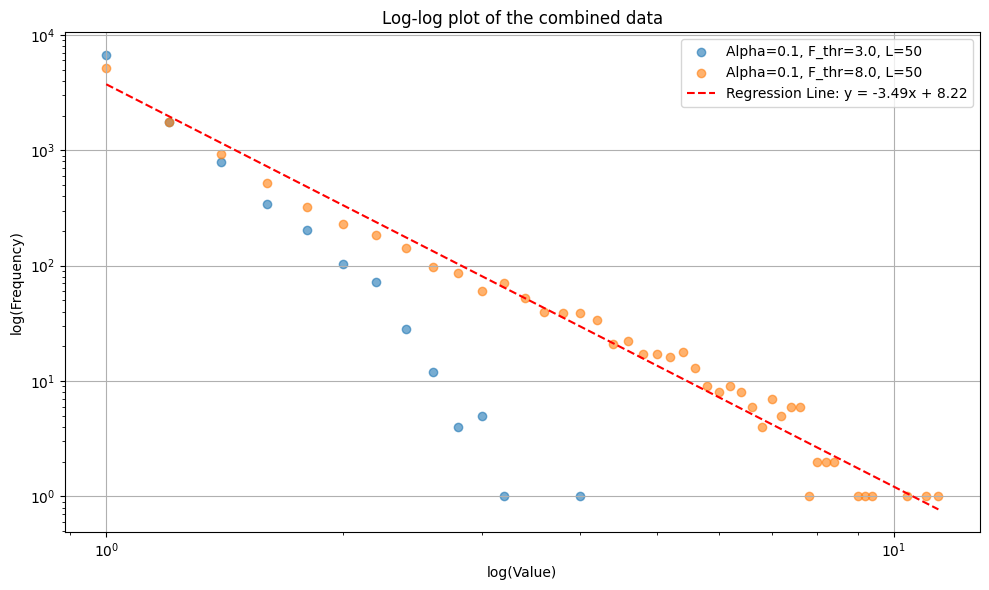

In [ ]:
# Define parameters to vary
alpha = 0.1  # Varying values for alpha
L = 50     # Varying values for L
thresholds = [3.0, 8.0] # Varying values for threshold

# Number of additions of force to the system
n_additions = 10000

# Number of simulations
n_simulations = 5

# Create a single plot
plt.figure(figsize=(10, 6))

for F_thr in thresholds:
    print(f"Running simulation for alpha={alpha}, L={L}, Threshold={F_thr}...")
    
    # Arrays to store results of each simulation
    active_sites_moore_array = []

    for z in range(n_simulations):
        print(round((z+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
        _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, 'moore')
        active_sites_moore_array.append(active_sites_moore)


    # Compute the average of the results
    average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
    
    # Process data
    occurrences_counter = Counter(average_active_sites_moore)
    magnitudes = list(occurrences_counter.keys())
    frequencies = list(occurrences_counter.values())
    values = np.array(list(occurrences_counter.keys()))
    frequencies = np.array(list(occurrences_counter.values()))

    # Filter
    non_zero_indices = values > 0
    values = values[non_zero_indices]
    frequencies = frequencies[non_zero_indices]
    
    # Use ODR to do Linear Regression
    linear_model = odr.Model(linear_func)
    data = odr.Data(np.log(values), np.log(frequencies))
    odr_obj = odr.ODR(data, linear_model, beta0=[0., 1.])
    output = odr_obj.run()

    slope, intercept = output.beta
    r_squared = output.res_var
    p_value = output.cov_beta[0, 0]
    std_err = output.sd_beta
    
    # Plot the data points with a unique color for each combination
    plt.scatter(values, frequencies, label=f'Alpha={alpha}, F_thr={F_thr}, L={L}', alpha=0.6)
    print("\n")

# Add linear regression line
x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept
plt.plot(np.exp(x), np.exp(y), color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

# Set plot labels and title
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-log plot of the combined data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()